In [554]:

from ROOT import TCanvas, TGraph, TH2D, TGraph2D, TIter, TPolyLine
from ctypes import c_double
import ROOT as root
from array import array
from sys import argv,stdout,exit
from glob import glob
from collections import namedtuple
import CMS_lumi as CMS_lumi

root.gStyle.SetOptStat(0)
root.gStyle.SetOptTitle(0)
root.gStyle.SetFrameLineWidth(2)
offshell=True
dosmooth = 'false'
root.gStyle.SetNumberContours(505);
root.gStyle.SetPalette(57)
# root.gStyle.SetFillColor(1)
# root.gStyle.SetFillStyle(3002)
XSECUNCERT=0.1
VERBOSE=False
drawLegend=True
iC=0

In [555]:
def get_contours(h2, cold):
    ctmp = TCanvas()
    ctmp.cd()
    h2.Draw("contlist")
    ctmp.Update()

    conts = root.gROOT.GetListOfSpecials().FindObject("contours")
    graphs = []
    for ib in range(conts.GetSize()):
        l = conts.At(ib)
        #graph = root.TGraph(l.First())                                                                                                                                                                         
        graph = l.First()
        if not graph:
            continue
        graph = root.TGraph(graph) # clone                                                                                                                                                                      
        graph.SetLineColor(h2.GetLineColor())
        graph.SetLineWidth(h2.GetLineWidth())
        graph.SetLineStyle(h2.GetLineStyle())
        graphs.append(graph)

    cold.cd()
    return graphs


In [556]:
L = namedtuple('L', ['mMed','mChi','down2','down1','cent','up1','up2','obs'])

def parseLimitFiles2D(filepath):
    limits = {}
    flist = list(open(filepath, 'r').readlines())
    for line in flist[1:]:
        l = L(*map(float, line.strip().split()))
        limits[(l.mMed , l.mChi )] = l
    print ('Successfully parsed %i points'%(len(limits)))
    return limits


In [557]:
def redrawBorder():
   root.gPad.Update()
   root.gPad.RedrawAxis()
   l = root.TLine()
   l.SetLineWidth(2)
   l.DrawLine(root.gPad.GetUxmin(), root.gPad.GetUymin(), root.gPad.GetUxmax(), root.gPad.GetUymin())
   l.DrawLine(root.gPad.GetUxmin(), root.gPad.GetUymin(), root.gPad.GetUxmin(), root.gPad.GetUymin())
   l.DrawLine(root.gPad.GetUxmin(), root.gPad.GetUymax(), root.gPad.GetUxmax(), root.gPad.GetUymax())
   l.DrawLine(root.gPad.GetUxmax(), root.gPad.GetUymax(), root.gPad.GetUxmax(), root.gPad.GetUymin())
   ## for background color inside the plot
   # root.gPad.GetFrame().SetFillColor(18)
   # root.gPad.GetFrame().SetBorderMode(-1)
   # root.gPad.GetFrame().SetBorderSize(5)

In [558]:
def SetLegend(coordinate_=[.50, .65, .90, .90], ncol=2):
    c_ = coordinate_
    legend = root.TLegend(c_[0], c_[1], c_[2], c_[3])
    legend.SetBorderSize(0)
    legend.SetNColumns(ncol)
    legend.SetLineColor(1)
    legend.SetLineStyle(1)
    legend.SetLineWidth(1)
    legend.SetFillColor(0)
    legend.SetFillStyle(0)
    legend.SetTextFont(42)
    legend.SetTextSize(0.04)
    return legend

Successfully parsed 81 points
138 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: grid (Potential memory leak).
Info in <TCanvas::Print>: png file limits_tanb_vs_ma_scan_rateparamModel_09052023.png has been created
Info in <TCanvas::Print>: pdf file limits_tanb_vs_ma_scan_rateparamModel_09052023.pdf has been created


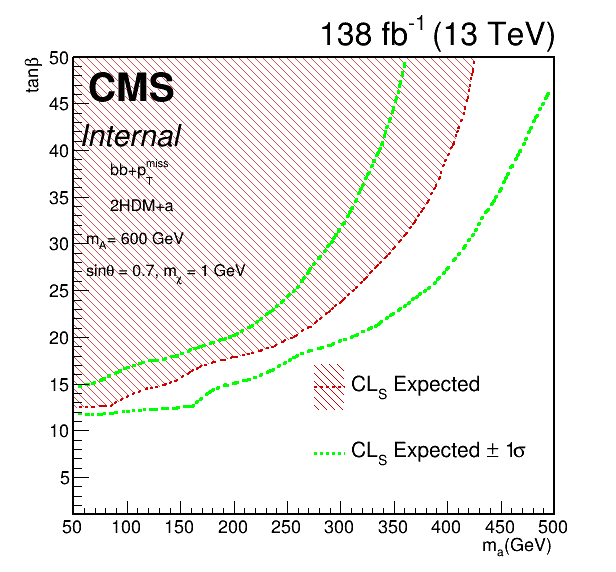

In [559]:
c = TCanvas("canvas", '',  620, 600)
c.SetGrid(0,0)
# c.SetTopMargin(0.05)
c.SetLeftMargin(0.12)
# c.SetRightMargin(0.05)
# c.SetBottomMargin(0.12)
c.SetFillColor(0)
c.cd()

legend = SetLegend([.50, .15, .78, .38], ncol=1)
#def makePlot2D(filepath,foutname,medcfg,chicfg,header='',offshell=False):
inFileName = "limits_tanb_vs_ma_scan_rateparamModel_09052023"
filepath= inFileName+".txt"

foutname="test_"
medcfg=[50,10,500]
chicfg=[50,1,50]
limits = parseLimitFiles2D(filepath)
    
gs = {} ## create a dict of 2D graphs 
for g in ['exp','expup','expdown','obs','obsup','obsdown','expup2','expdown2']:
    gs[g] = TGraph2D()
iP=0
## create a 2D histogram with binined sent from function call
hgrid = TH2D('grid','grid',medcfg[0],medcfg[1],medcfg[2],chicfg[0],chicfg[1],chicfg[2])
for p in limits: 
    mMed = p[0]; mChi = p[1]
    l = limits[p]
    if l.obs==0 or l.cent==0:
        print ("problematic point: ",mMed,mChi)
        continue
    ## fill 2d histo 
    hgrid.Fill(mMed,mChi,l.cent)
    ## fill graphs 
    gs['exp'].SetPoint(iP,mMed,mChi,l.cent)
    gs['expup'].SetPoint(iP,mMed,mChi,l.up1)
    gs['expdown'].SetPoint(iP,mMed,mChi,l.down1)
    gs['obs'].SetPoint(iP,mMed,mChi,l.obs)
    gs['obsup'].SetPoint(iP,mMed,mChi,l.obs/(1-XSECUNCERT))
    gs['obsdown'].SetPoint(iP,mMed,mChi,l.obs/(1+XSECUNCERT))
    gs['expup2'].SetPoint(iP,mMed,mChi,l.up2)
    gs['expdown2'].SetPoint(iP,mMed,mChi,l.down2)
    iP += 1
    
    hs = {}
    for h in ['exp']:#,'expup','expdown','obs','obsup','obsdown','expup2','expdown2']:
        hs[h] = TH2D(h,h,medcfg[0],medcfg[1],medcfg[2],chicfg[0],chicfg[1],chicfg[2])
        # hs[h].SetStats(0); hs[h].SetTitle('')                                                                                                                                                                 
        for iX in range(0,medcfg[0]):
            for iY in range(0,chicfg[0]):
                x = medcfg[1] + (medcfg[2]-medcfg[1])*iX/medcfg[0]
                y = chicfg[1] + (chicfg[2]-chicfg[1])*iY/chicfg[0]
                #print (x,y)
                if not(offshell) and 2*y>x:
                    val = 9999
                else:
                    val = gs[h]#.Interpolate(x,y)
                if val == 0:
                    val = 9999

#hgrid.Draw("colz")
#gs['exp'].Draw("COLZ same")


h_exp = gs['exp'].GetHistogram()
h_exp.Smooth(1)
h_exp.SetMarkerColor(0)
h_exp.SetMarkerSize(0)
h_exp.GetXaxis().SetTitle("m_{a}(GeV)")
h_exp.GetYaxis().SetTitle("tan#beta")
h_exp.GetXaxis().SetRangeUser(50,500)
h_exp.GetYaxis().SetRangeUser(1,50)
h_exp.GetYaxis().SetTitleOffset(1.2)
h_exp.Draw("")

h_expup1 =  gs['expup'].GetHistogram()
h_expup1.Smooth(1)
h_expdown1 =  gs['expdown'].GetHistogram()
h_expdown1.Smooth(1)

h_expup2 =  gs['expup2'].GetHistogram()
h_expup2.Smooth(1)
h_expdown2 =  gs['expdown2'].GetHistogram()
h_expdown2.Smooth(1)

h_obs = gs['obs'].GetHistogram()
h_obs.Smooth(1)

gExp = TGraph2D(h_exp)
gExpup1 = TGraph2D(h_expup1)
gExpdown1 = TGraph2D(h_expdown1)
gExpup2 = TGraph2D(h_expup2)
gExpdown2 = TGraph2D(h_expdown2)
g_obs = TGraph2D(h_obs)


g=TGraph()
g_up_one = TGraph()
g_down1 = TGraph()
g_up2 = TGraph()
g_down2 = TGraph()
g_o =  TGraph()
if gExp.GetContourList(1.) != 0: 
    list_ = (gExp.GetContourList(1.))
    list_iter = TIter(list_)
    g = TGraph(list_[0])
    list_up1 = (gExpup1.GetContourList(1.))
    g_up1 = TGraph(list_up1[0])
    list_down1 = (gExpdown1.GetContourList(1.))
    g_down1 = TGraph(list_down1[0])
    list_up2 = (gExpup2.GetContourList(1.))
    g_up2 = TGraph(list_up2[0])
    list_down2 = (gExpdown2.GetContourList(1.))
    g_down2 = TGraph(list_down2[0])
    list_o = (g_obs.GetContourList(1.))
    g_o = TGraph(list_o[0])

# g_down2.SetLineWidth(3)
# g_down2.SetLineStyle(2)
# g_down2.SetLineColor(root.kYellow)
# g_down2.Draw("F")

g_down1.SetLineWidth(3)
g_down1.SetLineStyle(2)
g_down1.SetLineColor(root.kGreen)
g_down1.Draw("L")

g.SetLineWidth(2)
g.SetLineStyle(2)
g.SetLineColor(root.kRed+1)
g.SetFillColorAlpha(root.kRed+1,1)  # Fill the area above the graph using the TPolyLine
g.SetFillStyle(3005)
g.Draw("same")
legend.AddEntry(g, "CL_{S} Expected ", "LF")

polyline = TPolyLine() # Create a TPolyLine to fill the area
n_points = g.GetN() # Get the number of points in the graph
x,y = c_double(0),c_double(0) # Prepare variables for GetPoint function
polyline.SetNextPoint(50, 12.3) # Add points to the TPolyLine to create the filled area
for i in range(n_points):
    g.GetPoint(i, x, y)
    polyline.SetNextPoint(x, y)
polyline.SetNextPoint(425, 50) 
polyline.SetNextPoint(50,50)  # Set y-coordinate to the maximum y-value polyline.SetNextPoint(g.GetXaxis().GetXmin(), g.GetYaxis().GetXmax())
polyline.SetFillColorAlpha(root.kRed+1, 0.7)  # Fill the area above the graph using the TPolyLine
polyline.SetFillStyle(3005)
polyline.Draw("F")

g_up1.SetLineWidth(3)
g_up1.SetLineStyle(2)
g_up1.SetLineColor(root.kGreen)
g_up1.Draw("same")
legend.AddEntry(g_up1, "CL_{S} Expected #pm 1#sigma", "LF")

# g_up2.SetLineWidth(3)
# g_up2.SetLineStyle(2)
# g_up2.SetLineColor(root.kYellow)
# g_up2.Draw("same")
# legend.AddEntry(g_up2, "CL_{S} Expected #pm 2#sigma", "l")

g_o.SetLineWidth(2)
g_o.SetLineColor(root.kRed+1)
# g_o.Draw("same")
# legend.AddEntry(g_o, "Observed", "l")

legend.Draw('same')
latex =  root.TLatex();
latex.SetNDC();
latex.SetTextFont(42);
latex.SetTextSize(0.03);
latex.SetTextAlign(31);
latex.SetTextAlign(12);
model = '2HDM+a'

category=""
MA_="600"
latex.DrawLatex(0.18, 0.7, "bb+p_{T}^{miss}  "+category)
latex.DrawLatex(0.18, 0.64, "2HDM+a")
latex.DrawLatex(0.14, 0.58, "m_{A}= "+MA_+" GeV")
latex.DrawLatex(0.14, 0.52, "sin#theta = 0.7, m_{#chi} = 1 GeV")

redrawBorder()

CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "Internal"
CMS_lumi.lumi_sqrtS = "13 TeV" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iPos = 11
if( iPos==0 ): CMS_lumi.relPosX = 0.12
iPeriod=161718
CMS_lumi.CMS_lumi(c, iPeriod, iPos)
c.Update()
c.Draw()
c.SaveAs(inFileName+".png")
c.SaveAs(inFileName+".pdf")
